In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/invstodata/HINDALCO_1D (1).xlsx - HINDALCO.csv


we will use linear regression with and without
shrinkage to predict returns and generate trading signals.

In [2]:
data = pd.read_csv("/kaggle/input/invstodata/HINDALCO_1D (1).xlsx - HINDALCO.csv")
data.head()

,datetime,close,high,low,open,volume,instrument,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,2014-01-24 00:00:00,114.00,115.35,113.00,113.15,5737135,HINDALCO,NaN,NaN,NaN,NaN,NaN
1,2014-01-27 00:00:00,111.10,112.70,109.30,112.00,8724577,HINDALCO,NaN,NaN,NaN,NaN,NaN
2,2014-01-28 00:00:00,113.80,115.00,109.75,110.00,4513345,HINDALCO,NaN,NaN,NaN,NaN,NaN
3,2014-01-29 00:00:00,111.75,114.75,111.15,114.50,4713458,HINDALCO,NaN,NaN,NaN,NaN,NaN
4,2014-01-30 00:00:00,108.10,110.70,107.60,110.20,5077231,HINDALCO,NaN,NaN,NaN,NaN,NaN


# Baseline Linear Regression Model

Pre Processing data

In [3]:
# clean data to include features that we want i.e close price
# Reindex data using a DatetimeIndex
data.set_index(pd.DatetimeIndex(data['datetime']), inplace=True)
close_data = data[['datetime','close']]
close_data['returns'] = data['close'].pct_change()
close_data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,datetime,close,returns
datetime,,,
2014-01-24,2014-01-24 00:00:00,114.00,NaN
2014-01-27,2014-01-27 00:00:00,111.10,-0.025439
2014-01-28,2014-01-28 00:00:00,113.80,0.024302
2014-01-29,2014-01-29 00:00:00,111.75,-0.018014
2014-01-30,2014-01-30 00:00:00,108.10,-0.032662


In [4]:
close_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1215 entries, 2014-01-24 00:00:00 to 2018-12-28 00:00:00
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  1215 non-null   object 
 1   close     1215 non-null   float64
 2   returns   1214 non-null   float64
dtypes: float64(2), object(1)
memory usage: 38.0+ KB


<AxesSubplot:xlabel='datetime', ylabel='close'>

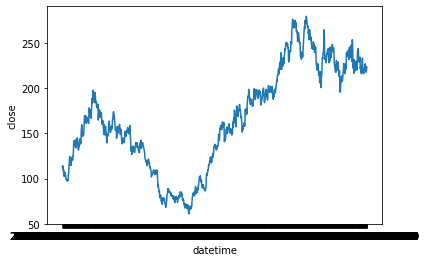

In [5]:
# we plot this data as a line plot to show the movements of price
import seaborn as sns

sns.lineplot(x="datetime", y="close", data=close_data)

We now add technical indicators to our analysis - used because these have been historically used by investors to predict the movements of stocks to best determine when to buy, sell, or hold.

We will use use pandas.ta to apply these indicators to the prices and the indicators that we will be using are Exponential Moving Average (EMA) and Relative Strength Index (RSI).

In [6]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 KB 697.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=46d020453a007d58aaa01d6e2e92a725007e147538a9369045375086082928c8
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas_ta


In [7]:
import pandas_ta

close_data.ta.ema(close='close', length=10, append=True)

/opt/conda/lib/python3.7/site-packages/pandas_ta/core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ind_name] = result


datetime
2014-01-24           NaN
2014-01-27           NaN
2014-01-28           NaN
2014-01-29           NaN
2014-01-30           NaN
                 ...    
2018-12-21    223.496068
2018-12-24    222.469510
2018-12-26    221.765963
2018-12-27    221.553970
2018-12-28    221.907793
Name: EMA_10, Length: 1215, dtype: float64

In [8]:
close_data.ta.rsi(close='close', length=10, append=True)

/opt/conda/lib/python3.7/site-packages/pandas_ta/core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ind_name] = result


datetime
2014-01-24          NaN
2014-01-27          NaN
2014-01-28          NaN
2014-01-29          NaN
2014-01-30          NaN
                ...    
2018-12-21    50.519616
2018-12-24    40.427848
2018-12-26    41.997832
2018-12-27    46.198985
2018-12-28    51.821180
Name: RSI_10, Length: 1215, dtype: float64

In [9]:
close_data = close_data.dropna()
close_data

,datetime,close,returns,EMA_10,RSI_10
datetime,,,,,
2014-02-07,2014-02-07 00:00:00,106.40,0.006147,108.052727,38.427419
2014-02-10,2014-02-10 00:00:00,106.80,0.003759,107.824959,40.289541
2014-02-11,2014-02-11 00:00:00,104.55,-0.021067,107.229512,33.884748
2014-02-12,2014-02-12 00:00:00,103.50,-0.010043,106.551419,31.304377
2014-02-13,2014-02-13 00:00:00,100.20,-0.031884,105.396615,24.728450
...,...,...,...,...,...
2018-12-21,2018-12-21 00:00:00,224.00,0.000447,223.496068,50.519616
2018-12-24,2018-12-24 00:00:00,217.85,-0.027455,222.469510,40.427848
2018-12-26,2018-12-26 00:00:00,218.60,0.003443,221.765963,41.997832


<AxesSubplot:xlabel='datetime'>

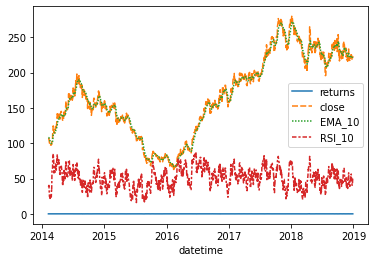

In [10]:
# plotting the three indicators together
sns.lineplot(data=close_data[['returns','close','EMA_10','RSI_10']])

# Testing for Linear Regression (Statistical Inference)

We now conduct a statistical inference test using Gauss Markov Theorem for the following assumptions for baseline multiple regression model :

- In the population, linearity holds
- The data for the input variables is a random sample from the population.
- No perfect collinearity—there are no exact linear relationships among the input variables.
- The error has a conditional mean of zero given any of the inputs
- Homoskedasticity

We check for 3,4 and 5 since 1 and 2 are already satisfied

In [11]:
close_data.corr()

,close,returns,EMA_10,RSI_10
close,1.000000,0.026614,0.995501,0.141017
returns,0.026614,1.000000,-0.025626,0.407043
EMA_10,0.995501,-0.025626,1.000000,0.057863
RSI_10,0.141017,0.407043,0.057863,1.000000


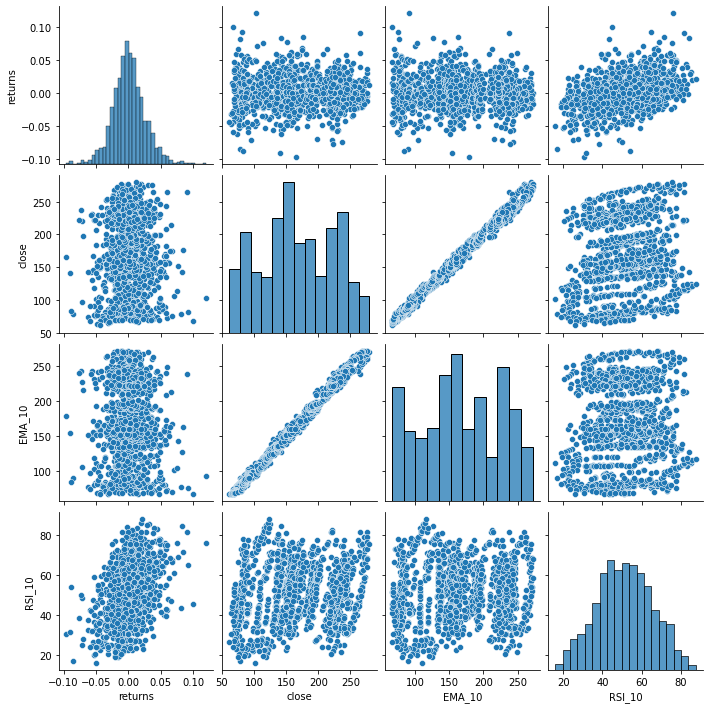

In [12]:
# checking for 3
sns.pairplot(close_data[['returns','close','EMA_10','RSI_10']])

In [13]:
import statsmodels.api as sm
mod = sm.OLS(close_data['returns'], close_data[['close','EMA_10','RSI_10']])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                returns   R-squared (uncentered):                   0.305
Model:                            OLS   Adj. R-squared (uncentered):              0.303
Method:                 Least Squares   F-statistic:                              175.8
Date:                Sun, 22 May 2022   Prob (F-statistic):                    1.65e-94
Time:                        16:15:06   Log-Likelihood:                          2945.9
No. Observations:                1205   AIC:                                     -5886.
Df Residuals:                    1202   BIC:                                     -5871.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The things that we need to look at :

- standard error estimates do not account for heteroskedasticity. (almost 0)
- The Durbin Watson Statistic = 2.005 which implies the absense of autocorrelation
- The input variables are not completely correlated to the returns 
- The $R^2$ is 0.305 which suggests a bad fit which is to be expected since this is a baseline model

# Multiple Linear Regression for Prediction
We now fit the data as a multiple linear regression to fit the data

In [14]:
# Split data into testing and training sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(close_data[['returns']], close_data[['EMA_10','close','RSI_10']], test_size=.2)


In [15]:
from sklearn.linear_model import LinearRegression
# Create Regression Model
model = LinearRegression()
# Train the model
model.fit(X_train, y_train)
# Use model to make predictions
y_pred = model.predict(X_test)

In [16]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Printout relevant metrics
print("Model Coefficients:", model.coef_)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Coefficient of Determination:", r2_score(y_test, y_pred))


Model Coefficients: [[-33.17960698]
 [ 88.71448888]
 [236.77730807]]
Mean Absolute Error: 36.47117769581052
Coefficient of Determination: 0.03827801704677025


The Mean Absolute Error(MAE) can be described as the sum of the absolute error for all observed values divided by the total number of observations. 

a lower MAE value is better, and the closer our coefficient of the correlation value is to 1.0 the better. 

We recognise the high error of the model here as it is our baseline model and that it could be fit better.

# Shrinkage Methods : Ridge and Lasso Regression
**Ridge regression :** shrinks the regression coefficients by adding
a penalty to the objective function that equals the sum of the
squared coefficients, which in turn corresponds to the L2 norm
of the coefficient vector

Ridge regression shrinks the coefficients relative to the
alignment of input variables with the directions in the data that
exhibit most variance. More specifically, it shrinks those
coefficients the most that represent inputs aligned with the
principal components that capture less variance. Hence, the
assumption that's implicit in ridge regression is that the
directions in the data that vary the most will be most
influential or most reliable when predicting the output.

In [17]:
from sklearn.linear_model import *
from sklearn.metrics import r2_score
rid = Ridge()
a = rid.fit(X_train,y_train)

x_test_pred_rd = rid.predict(X_test)

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Model Coefficients:", a.coef_)
print("R2 score:", r2_score(y_test, x_test_pred_rd))

Mean Absolute Error: 36.47117769581052
Model Coefficients: [[-12.29329349]
 [ 32.86938417]
 [ 87.7277703 ]]
R2 score: 0.025193425638530925


**Lasso Regression:** The lasso (Hastie, Tibshirani, and Wainwright 2015), known as
basis pursuit in signal processing, also shrinks the coefficients
by adding a penalty to the sum of squares of the residuals, but
the lasso penalty has a slightly different effect. The lasso
penalty is the sum of the absolute values of the coefficient
vector, which corresponds to its L1 norm. 

The lasso penalty had the effect of gradually reducing some
coefficients to zero as the regularization increases. For this
reason, the lasso can be used for the continuous selection of a
subset of features.

In [18]:
from sklearn.linear_model import Lasso

model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)
print("Mean Absolute Error:")
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

Mean Absolute Error:
46.69201279827549
0.05759633644550799
